In [23]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib

In [25]:

# Set memory management env variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [41]:
# === LOAD METADATA AND FILTER B0006 DISCHARGE CYCLES ===
def load_discharge_files(metadata_path, csv_folder):
    metadata = pd.read_csv(metadata_path)
    # Filter for B0006 battery discharge cycles
    discharge_files = metadata[(metadata['type'] == 'discharge') & (metadata['battery_id'] == 'B0006')]['filename'].tolist()
    print(f"Found {len(discharge_files)} discharge cycles for B0006: {discharge_files[:5]}...")
    return discharge_files

In [43]:
# === LOAD AND PREPROCESS DATA FOR PREDICTION ===
def load_data_for_prediction(discharge_files, csv_folder, sequence_length=64, scaler_path="scaler_x.pkl"):
    all_data = []
    for file in discharge_files:
        file_path = os.path.join(csv_folder, file)
        if os.path.exists(file_path):
            # Load CSV with expected column names for NASA dataset (no SOC column)
            df = pd.read_csv(file_path, usecols=['Voltage_measured', 'Current_measured', 'Time'])
            all_data.append(df)
        else:
            print(f"⚠️ File not found: {file_path}")

    if not all_data:
        print("⚠️ No discharge data found for B0006. Exiting.")
        exit()

    df = pd.concat(all_data, ignore_index=True)
    
    # Load the pre-trained scaler
    scaler_x = joblib.load(scaler_path)
    # Apply scaler with original column names (as seen during fit)
    df[['Voltage_measured', 'Current_measured', 'Time']] = scaler_x.transform(df[['Voltage_measured', 'Current_measured', 'Time']])

    # Rename columns to match expected input for the model (Voltage, Current, Time)
    df = df.rename(columns={
        'Voltage_measured': 'Voltage',
        'Current_measured': 'Current',
        'Time': 'Time'
    })

    data = df[['Voltage', 'Current', 'Time']].values  # Features (Voltage, Current, Time)

    X = []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])

    X = np.array(X)
    print(f"B0006 discharge dataset shape: X shape: {X.shape}")

    return X


In [45]:
# === LSTM-ATTENTION MODEL ===
class LSTM_Attention_SOC(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, num_heads=4, dropout=0.2):
        super(LSTM_Attention_SOC, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, 
                                               num_heads=num_heads, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.fc(attn_out[:, -1, :])
        return out


In [47]:
# === TRANSFORMER MODEL ===
class TransformerSOC(nn.Module):
    def __init__(self, input_size=3, d_model=32, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerSOC, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 64, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_projection(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x

In [49]:
# === LOAD AND PREDICT WITH LSTM-ATTENTION ===
def load_lstm_attention_predictions(X_data, model_path="lstm_attention_soc_v2.pkl", batch_size=16):
    model = LSTM_Attention_SOC(input_size=3, hidden_size=32, num_layers=2, num_heads=4).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, torch.zeros(X_tensor.shape[0], 1))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    y_pred_list = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
    
    y_pred = np.concatenate(y_pred_list, axis=0)
    print("✅ LSTM-Attention predictions made for B0006")
    return y_pred

In [51]:
# === LOAD AND PREDICT WITH TRANSFORMER ===
def load_transformer_predictions(X_data, model_path="transformer_soc_v2.pkl", batch_size=16):
    model = TransformerSOC(input_size=3, d_model=32, nhead=4, num_layers=2).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, torch.zeros(X_tensor.shape[0], 1))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    y_pred_list = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
    
    y_pred = np.concatenate(y_pred_list, axis=0)
    print("✅ Transformer predictions made for B0006")
    return y_pred


Found 168 discharge cycles for B0006: ['04506.csv', '04508.csv', '04510.csv', '04512.csv', '04514.csv']...
B0006 discharge dataset shape: X shape: (50221, 64, 3)
✅ LSTM-Attention predictions made for B0006
✅ Transformer predictions made for B0006

Ensemble Weights - LSTM-Attention: 0.6781, Transformer: 0.3219
📊 Prediction plot saved to ensemble_predictions_b0006_discharge_no_soc.png
📄 Predicted SOC values saved to b0006_discharge_soc_predictions.csv


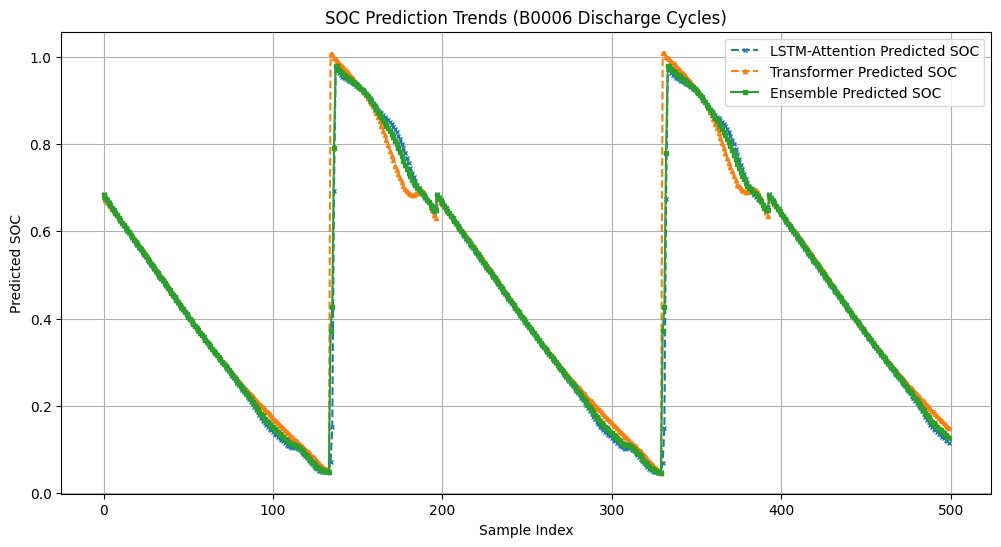

In [53]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
    csv_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"

    # Load metadata and filter B0006 discharge cycles
    discharge_files = load_discharge_files(metadata_path, csv_folder)

    if not discharge_files:
        print("⚠️ No discharge cycles found for B0006 in metadata. Please check the metadata file.")
        exit()

    # Load the data for B0006 discharge cycles
    X_discharge = load_data_for_prediction(discharge_files, csv_folder)

    if X_discharge.shape[0] == 0:
        print("⚠️ No discharge data found for B0006 after preprocessing. Please check the data or preprocessing steps.")
        exit()

    # Make predictions using pre-trained models
    lstm_y_pred = load_lstm_attention_predictions(X_discharge)
    transformer_y_pred = load_transformer_predictions(X_discharge)

    # Weighted ensemble (using best test losses from prior training)
    lstm_best_test_loss = 0.000047  # From your training results
    transformer_best_test_loss = 0.000099  # From your training results
    total_loss = lstm_best_test_loss + transformer_best_test_loss
    lstm_weight = (1 / lstm_best_test_loss) / ((1 / lstm_best_test_loss) + (1 / transformer_best_test_loss))
    transformer_weight = (1 / transformer_best_test_loss) / ((1 / lstm_best_test_loss) + (1 / transformer_best_test_loss))
    print(f"\nEnsemble Weights - LSTM-Attention: {lstm_weight:.4f}, Transformer: {transformer_weight:.4f}")

    ensemble_y_pred = lstm_weight * lstm_y_pred + transformer_weight * transformer_y_pred

    # Plot predictions (first 500 samples to visualize trends across cycles)
    plt.figure(figsize=(12, 6))
    plt.plot(lstm_y_pred[:500], label='LSTM-Attention Predicted SOC', marker='x', linestyle='--', markersize=3)
    plt.plot(transformer_y_pred[:500], label='Transformer Predicted SOC', marker='^', linestyle='--', markersize=3)
    plt.plot(ensemble_y_pred[:500], label='Ensemble Predicted SOC', marker='s', linestyle='-', markersize=3)
    plt.title('SOC Prediction Trends (B0006 Discharge Cycles)')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted SOC')
    plt.legend()
    plt.grid(True)
    plt.savefig('ensemble_predictions_b0006_discharge_no_soc.png')
    print("📊 Prediction plot saved to ensemble_predictions_b0006_discharge_no_soc.png")

    # Save the ensemble predictions to a CSV file
    predictions_df = pd.DataFrame({
        'LSTM_Attention_SOC': lstm_y_pred.flatten(),
        'Transformer_SOC': transformer_y_pred.flatten(),
        'Ensemble_SOC': ensemble_y_pred.flatten()
    })
    predictions_df.to_csv('b0006_discharge_soc_predictions.csv', index=False)
    print("📄 Predicted SOC values saved to b0006_discharge_soc_predictions.csv")

    if device.type == "cuda":
        torch.cuda.empty_cache()